# Loading/cleaning/examining the City of Boston health inspections records
Source: [data.cityofboston.gov](https://data.cityofboston.gov/Health/Food-Establishment-Inspections/qndu-wx8w), with the dataset downloaded in CSV format to `data/Food_Establishment_Inspections.csv`

In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import scipy.stats as stats
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
inspections = pd.read_csv(
    'data/Food_Establishment_Inspections.csv', 
    usecols = ['BusinessName', 'LICENSECAT',
       'DESCRIPT', 'RESULT', 'RESULTDTTM', 'Violation', 'ViolLevel',
       'ViolDesc', 'VIOLDTTM', 'ViolStatus', 'StatusDate', 'Comments', 'Address', 'City', 'State', 'Zip', 'Location'
    ],
    parse_dates = ['RESULTDTTM', 'VIOLDTTM', 'StatusDate'], 
    infer_datetime_format = True
)

# Rename variables for convenience:
inspections.columns = [
    'name',           # business name
    'category',       # business category ("FS", "FT", "RS", or "MFW")
    'type',           # more verbal description of business category 
    'result',         # result of the inspection (12 different possibilities)
    'result_date',    # date of inspection
    'violation',      # code for violation type
    'level',          # violation severity (can be * or ** or ***)
    'description',    # verbal description of violation
    'violation_date', # generally (or always?) the same as result_date
    'status',         # simply pass or fail
    'status_date',    # generally a day or so later than result_date, but often not given
    'comments',       # free-form text comments
    'address',
    'city',
    'state',
    'zip',
    'location'        # (latitude, longitude)
]

# Cut off any data from before August 1, 2011, since there are no 311 service records from before that time:
inspections = inspections[
    (inspections.result_date.astype(str) >= '2011-08-01') 
]

# Split the "location" data into separate latitude and longitude entries:
inspections['location'] = inspections.location.str.strip('()')
inspections[['latitude','longitude']] = inspections['location'].apply(lambda x: pd.Series(str(x).split(',')))
inspections['latitude'] = pd.to_numeric(inspections.latitude, errors='coerce')
inspections['longitude'] = pd.to_numeric(inspections.longitude, errors='coerce')

# Create a Google-searchable address for each establishment, so that those without latitude/longitude information
# can be filled in via the Google Maps Geocoding API, if desired:
inspections[['address']] = (
    inspections.address.fillna(inspections.name) + ', ' + inspections.city.fillna('Boston') + ', ' 
    + inspections.state.fillna('MA') + (' 0'+inspections.zip.fillna(0).astype(int).astype(str)).replace(' 00','')
)
inspections = inspections.drop(['city', 'state', 'zip', 'location'], 1)

In [3]:
# Take a look at the records for August 12, 2014:
inspections[
    inspections.result_date.astype(str).str.startswith('2014-08-12')
].sort_values(['name'])[[
        'name', 'category', 'result', 'level', 'description', 'comments', 'latitude', 'longitude'
    ]]

,name,category,result,level,description,comments,latitude,longitude
363935,A C Farm Market,RF,HE_Pass,**,Insects Rodents Animals,Evidence of fruit flies provide exterminators ...,42.302302,-71.059800
389871,A C Farm Market,RF,HE_Pass,*,Food Protection,Discontinue store vegetables in stagnant wate...,42.302302,-71.059800
372093,A C Farm Market,RF,HE_Pass,*,Dishwashng Facilities,Replace missing sink plugs.,42.302302,-71.059800
360435,A C Farm Market,RF,HE_Pass,*,Non-Food Contact Surfaces,Repair rusty shelving below prep table.,42.302302,-71.059800
374145,A C Farm Market,RF,HE_Pass,*,Food Container Labels,Provide labels for all packaged foods.,42.302302,-71.059800
147023,Choice's by Au Bon Pain,FT,HE_Fail,***,Cold Holding,salad bar/carrot and raisin salad 49 degrees/c...,NaN,NaN
146643,Choice's by Au Bon Pain,FT,HE_Fail,*,Equipment Thermometers,front line/ 2 door drawer/provide internal the...,NaN,NaN
144503,Choice's by Au Bon Pain,FT,HE_Fail,*,Improper Maintenance of Floors,replace damaged floor tile in front of proof b...,NaN,NaN
142939,Choice's by Au Bon Pain,FT,HE_Fail,*,Non-Food Contact Surfaces,bakery/replace worn door gasket to 1 door reac...,NaN,NaN
142060,Choice's by Au Bon Pain,FT,HE_Fail,*,Non-Food Contact Surfaces Clean,salad bar/clean interior cabinets,NaN,NaN


In [4]:
# Find the number of businesses inspected, and the number that have ever failed:
len(
    inspections[
        inspections.result_date.astype(str) < '2015-06-25'
    ].name.unique()
), len(
    inspections[
        (inspections.result_date.astype(str) < '2015-06-25')
        & (inspections.status == 'Fail')
    ].name.unique()
)

(5604, 3876)

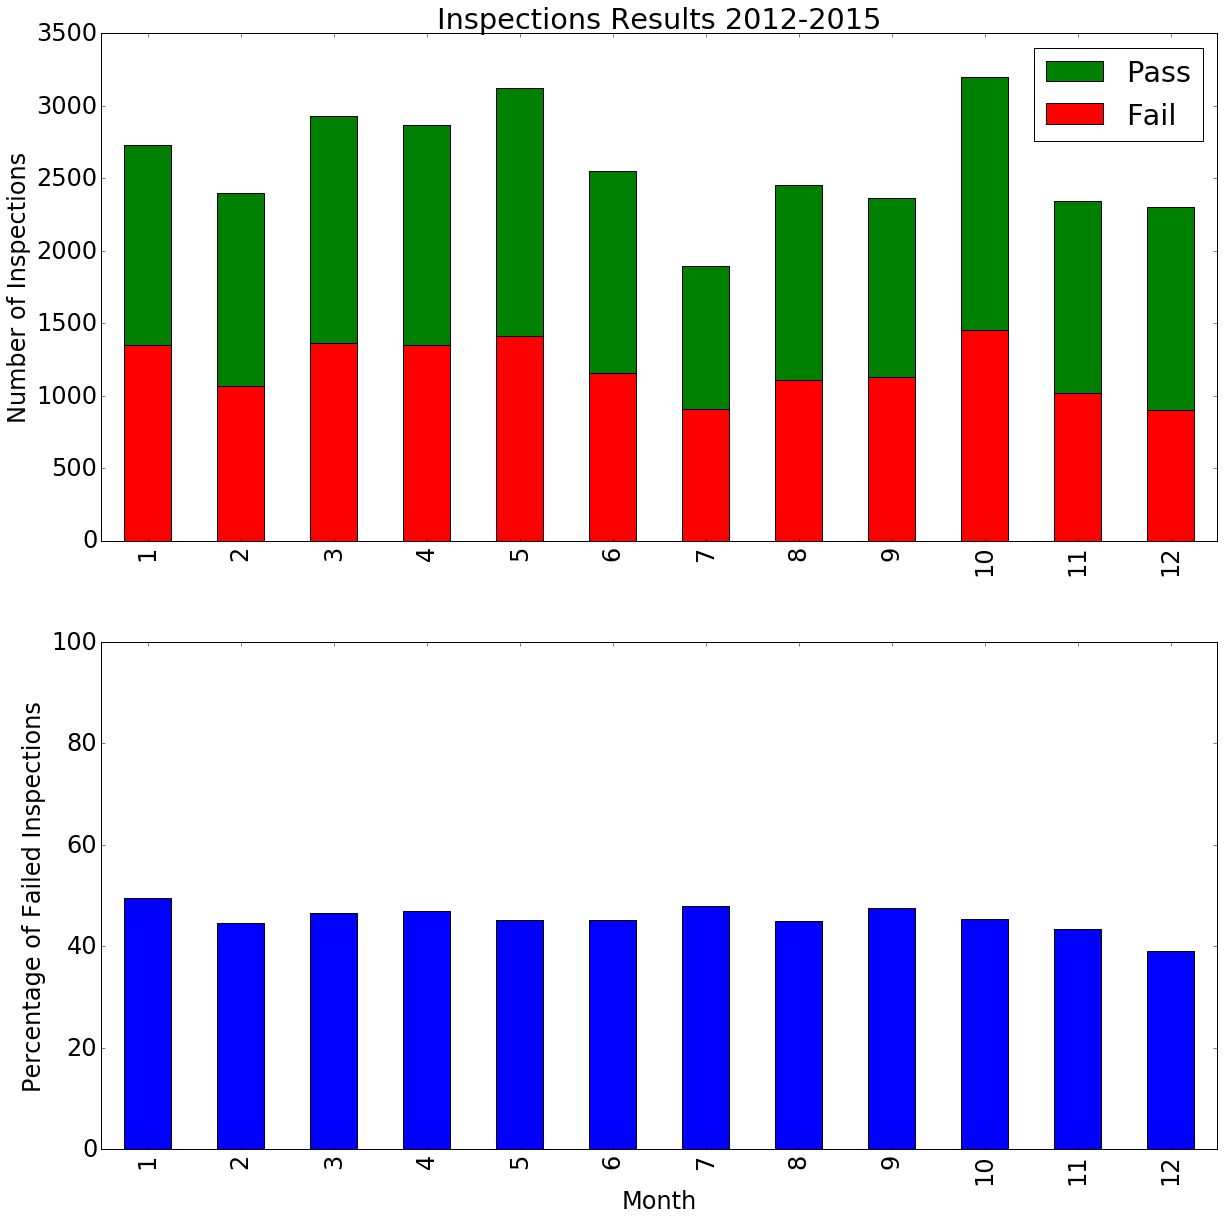

In [5]:
# To visualize patterns of inspections and failures in time...
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['font.size'] = 24
# In one bar chart, show all 2012-2015 inspections, broken down by month:
plt.subplot(2,1,1)
ax = inspections[
    (inspections.violation_date >= '2012-01-01 00:00:00') &
    (inspections.violation_date <= '2015-12-31 00:00:00')
].groupby(
    ['result_date', 'name']
).sum().reset_index('result_date').result_date.dt.month.value_counts().sort_index().plot(
    kind = 'bar', color='green'
)
# Also show the failed inspections:
inspections[
    (inspections.result.str.contains('Fail')) & 
    (inspections.violation_date >= '2012-01-01 00:00:00') &
    (inspections.violation_date <= '2015-12-31 00:00:00')
].groupby(
    ['result_date', 'name']
).sum().reset_index('result_date').result_date.dt.month.value_counts().sort_index().plot(
    kind = 'bar', ax = ax, color = 'red'
)
plt.title('Inspections Results 2012-2015')
plt.legend(['Pass','Fail'])
plt.ylabel('Number of Inspections')
# In another chart, show the 2012-2015 failure rate, broken down by month:
plt.subplot(2,1,2)
((
    (inspections[
            (inspections.result.str.contains('Fail')) & 
            (inspections.violation_date >= '2012-01-01 00:00:00') &
            (inspections.violation_date <= '2015-12-31 00:00:00')
        ].groupby(
                ['result_date', 'name']
            ).sum().reset_index('result_date').result_date.dt.month.value_counts().sort_index()) 
    / 
    (inspections[
            (inspections.violation_date >= '2012-01-01 00:00:00') &
            (inspections.violation_date <= '2015-12-31 00:00:00')
            ].groupby(
                ['result_date', 'name']
            ).sum().reset_index('result_date').result_date.dt.month.value_counts().sort_index())
)*100).plot(kind = 'bar', ylim=[0, 100])
plt.xlabel('Month')
plt.ylabel('Percentage of Failed Inspections')
None

In [6]:
# Find the number of businesses that have ever had rodent issues:
len(
    inspections[
        (inspections.result_date.astype(str) < '2015-06-25')
        & (inspections.description.str.contains('odent'))
    ].name.unique()
)

1236

# Loading/cleaning/examining the Yelp (condensed) health inspections records
Sources: [DrivenData.org](https://www.drivendata.org/competitions/5/page/17/) and [Yelp.com](https://www.yelp.com/dataset_challenge/drivendata), saving the datasets as
* `data/AllViolations.csv`
* `data/restaurant_ids_to_yelp_ids.csv`
* `data/yelp_academic_dataset_business.json`

In [7]:
# Load the inspections results data:
violations = pd.read_csv(
    'data/AllViolations.csv', 
    parse_dates = ['date'], 
    infer_datetime_format = True,
    index_col = 0
)

In [8]:
# Convert the file of businesses' details to a proper JSON string:
import json
with open('data/yelp_academic_dataset_business.json', 'r') as f:
    data = f.readlines()
data = map(lambda x: x.rstrip(), data)
data_json_str = '[' + (',').join(data) + ']'

# Convert the string to a dataframe:
business = pd.read_json(data_json_str)
business = business[[
    'name',
    'full_address',
    'city',
    'business_id',
    'latitude',
    'longitude'
]]

# Rename the variables for convenience:
business.columns = [
    'name',     
    'address',
    'city',
    'yelp_id',
    'latitude',
    'longitude'
]

# Dump the intermediate data used to produce the business details dataframe:
%reset_selective -f data_json_str
%reset_selective -f data

In [9]:
# Load the table for converting between "ID" systems:
idtable = pd.read_csv(
    'data/restaurant_ids_to_yelp_ids.csv'
)

# Reshape the table for easier use:
idtable = pd.concat([
        idtable[['restaurant_id','yelp_id_0']].rename(columns = {'yelp_id_0':'yelp_id'}),
        idtable[idtable.yelp_id_1.notnull()][['restaurant_id','yelp_id_1']].rename(columns = {'yelp_id_1':'yelp_id'}),
        idtable[idtable.yelp_id_2.notnull()][['restaurant_id','yelp_id_2']].rename(columns = {'yelp_id_2':'yelp_id'}),
        idtable[idtable.yelp_id_3.notnull()][['restaurant_id','yelp_id_3']].rename(columns = {'yelp_id_3':'yelp_id'})
], ignore_index = True)

In [10]:
# Combine the datasets to provide each inspected business with latitude/longitude information:
violations = violations.merge(
    idtable, 
    on = 'restaurant_id'
).merge(
    business, 
    on = 'yelp_id'
).drop(['yelp_id', 'address', 'city'], 1)

# As before, cut off any records before August 1, 2011:
violations = violations[violations.date >= '2011-08-01']

In [11]:
# Take a look at the records for August 12, 2014:
violations[violations.date == '2014-08-12'].sort_values('name')

,date,restaurant_id,*,**,***,name,latitude,longitude
8004,2014-08-12,we39j9ok,4,0,0,Dunkin' Donuts,42.349264,-71.042474
20155,2014-08-12,lnORdd3N,0,0,0,Dunkin' Donuts,42.356527,-71.053353
33990,2014-08-12,KAoK8ZOg,0,0,0,Fóumami,42.356039,-71.053455
7757,2014-08-12,0ZEDGWOD,9,0,0,Great Chef Chinese Food Day Square,42.379525,-71.027940
1423,2014-08-12,njoZ1D3r,3,0,1,Kantin,42.352744,-71.125447
2566,2014-08-12,eVOBLr3j,1,0,1,Lollicup,42.352444,-71.125403
35075,2014-08-12,B1oXNlEV,11,1,3,Max Brenner,42.349491,-71.080588
25898,2014-08-12,B1oX4boV,4,0,1,Samurai Kuang Eatery,42.355741,-71.058335
28452,2014-08-12,8xExZeo0,4,1,1,South Boston Chinese Restaurant,42.336483,-71.047309


In [12]:
# Find the number of businesses inspected, and the number that have ever failed:
len(
    violations[
        violations.date.astype(str) < '2015-06-25'
    ].name.unique()
), len(
    violations[
        (violations.date.astype(str) < '2015-06-25')
        & (violations['*'] + violations['**'] + violations['***'] > 0)
    ].name.unique()
)

(1634, 1327)

# Loading/cleaning/examining the service request call records
Source: [data.cityofboston.gov](https://data.cityofboston.gov/City-Services/311-Service-Requests/awu8-dc52), with the dataset downloaded in CSV format to `data/311__Service_Requests.csv`

In [13]:
services = pd.read_csv(
    'data/311__Service_Requests.csv', 
    usecols = [
       'OPEN_DT', 'CLOSED_DT', 'CASE_STATUS', 'CLOSURE_REASON', 'CASE_TITLE', 'SUBJECT', 'REASON',
       'TYPE', 'LATITUDE', 'LONGITUDE'
    ],
    parse_dates=['OPEN_DT', 'CLOSED_DT'], 
    infer_datetime_format = True
)

# Rename variables for convenience:
services.columns = [
    'open',         # date the complaint was registered
    'closed',       # date the complaint was resolved
    'status',       # open or closed
    'closure',      # details of how the complaint was closed (NaN if open)
    'title',        # description of the issue
    'subject',      # category of the issue (e.g. public works, civil rights, animal control, etc.)
    'reason',       # more specific category (often very similar to the "title")
    'type',         # usually identical to the "title" 
    'latitude',      
    'longitude'      
]
services = services.sort_values(['open', 'reason'])

# Take a look at a few randomly-selected service calls:
services.sample(10)

,open,closed,status,closure,title,subject,reason,type,latitude,longitude
348643,2013-11-05 07:25:31,2013-11-05 11:40:15,Closed,Case Closed Case Resolved,PWD Graffiti,Public Works Department,Highway Maintenance,PWD Graffiti,42.3103,-71.0820
124703,2014-04-23 11:45:44,2014-04-23 11:46:45,Closed,Case Closed Case Invalid Opened in error,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,42.3670,-71.0548
404127,2012-03-15 12:01:46,2012-03-15 12:01:46,Closed,Case Closed Internal Case Performed by Highway...,Pothole Repair (Internal),Public Works Department,Highway Maintenance,Pothole Repair (Internal),42.2758,-71.1211
435326,2012-11-07 22:00:19,2012-11-08 07:47:42,Closed,Case Closed Case Resolved street sanded,Request for Snow Plowing,Public Works Department,Street Cleaning,Request for Snow Plowing,42.3176,-71.0891
447702,2013-09-13 20:21:13,2013-09-16 11:17:49,Closed,Case Closed Case Noted duplicate to #926952,Requests for Street Cleaning,Public Works Department,Street Cleaning,Requests for Street Cleaning,42.2559,-71.1213
228163,2014-06-19 17:10:43,2014-06-20 08:33:15,Closed,Case Closed Case Noted the signs are correct ...,No-Tow Complaint Confirmation,Public Works Department,Administrative & General Requests,No-Tow Complaint Confirmation,42.3126,-71.0585
568066,2015-06-10 08:14:16,2015-06-10 08:15:48,Closed,Case Closed. Closed date : 2015-06-10 08:15:48...,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,42.2821,-71.0541
214825,2011-07-20 14:49:28,2012-07-24 15:25:29,Closed,Case Closed VIOISS: Violation Filed,Work w/out Permit,Inspectional Services,Building,Work w/out Permit,42.3791,-71.0624
386446,2012-08-07 13:41:56,2012-08-09 21:47:52,Closed,Case Closed Bulk Item Automation,Schedule a Bulk Item Pickup,Public Works Department,Sanitation,Schedule a Bulk Item Pickup,42.3504,-71.1670
513009,2014-03-19 14:55:52,2014-03-20 09:48:45,Closed,Case Closed Case Resolved filled by patch c...,Request for Pothole Repair,Public Works Department,Highway Maintenance,Request for Pothole Repair,42.2910,-71.0639


In [14]:
# Count how many different titles, subjects, reasons, and types there are:
(
    len(services.title.unique()), 
    len(services.subject.unique()), 
    len(services.reason.unique()), 
    len(services.type.unique())
)

(7837, 18, 61, 215)

In [15]:
# Retrieve a list of the various "reasons" that have been used for service calls, sorted by prevalence:
reason = services.reason.value_counts().reset_index()

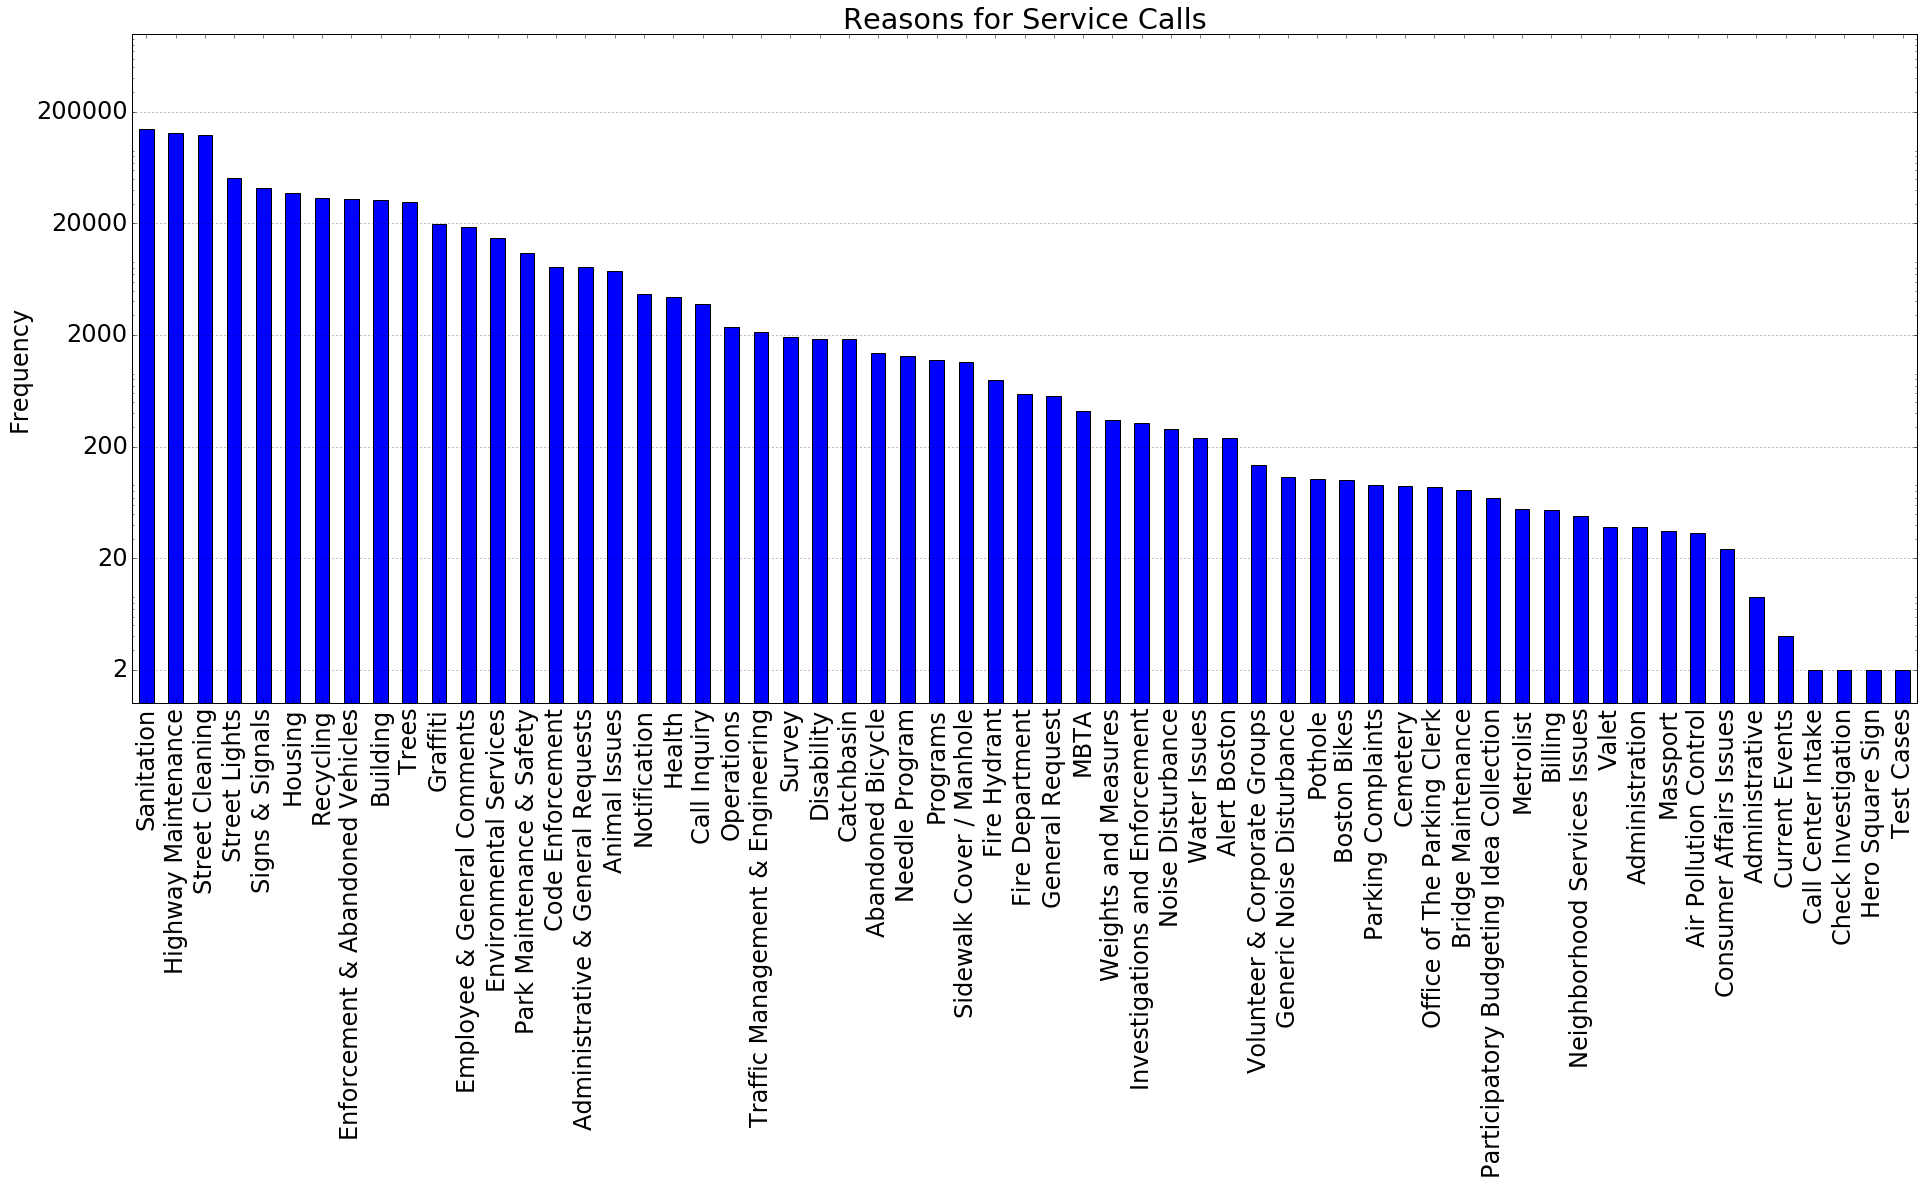

In [16]:
# Plot the prevalences of the service call reasons:
plt.rcParams['figure.figsize'] = (32, 12)
plt.rcParams['font.size'] = 24
ax = reason.plot(kind = 'bar', log = True)
ax.set_xticklabels(reason['index'])
ax.set_yticks([2,20,200,2000,20000,200000])
ax.set_yticklabels([2,20,200,2000,20000,200000])
ax.legend_.remove()
ax.grid(axis = 'y')
ax.set_title('Reasons for Service Calls')
ax.set_ylabel('Frequency')
None

In [17]:
# Store only the names of the top 54 reasons for later use:
reason = reason.head(54)['index']

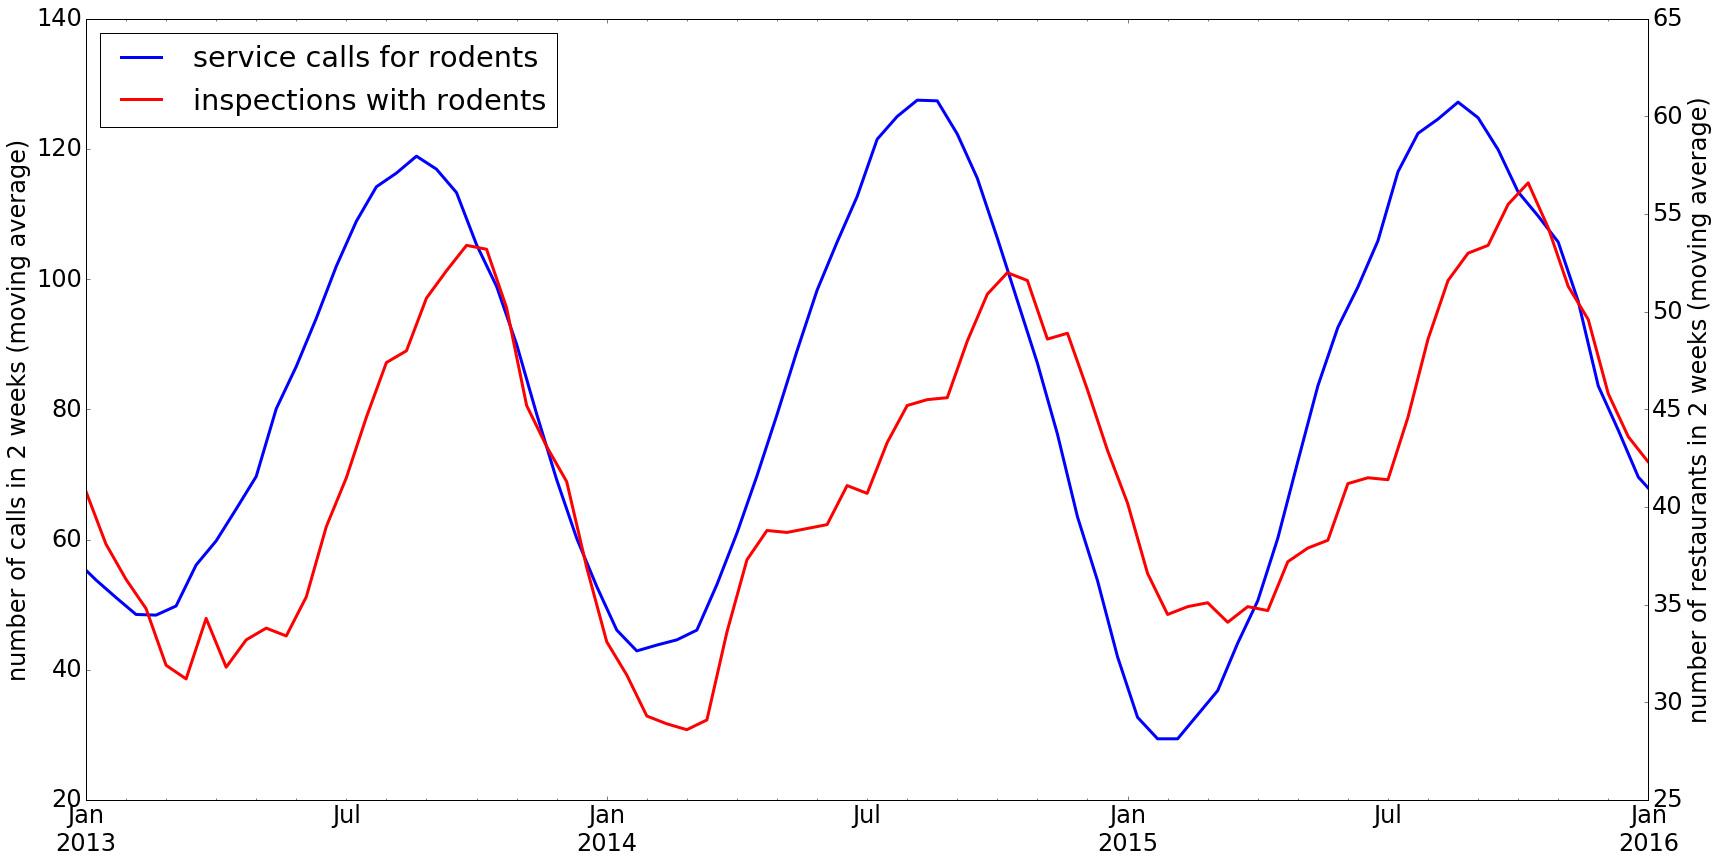

In [18]:
# To compare the time series of rodent sightings and rodent issues...
plt.rcParams['figure.figsize'] = (28, 14)
plt.rcParams['font.size'] = 24

# Create a smooth (i.e. rolling averaged) graph of rodent sighting counts:
ax = services[services.title.fillna('').str.contains('odent')].set_index(
    'open'
)[['status']].rename(columns = {'status':'service calls for rodents'}).resample('2w').count().fillna(0).rolling(
    window=10, min_periods=1, center=True
).mean().plot(
    kind='line', 
    linewidth = 3,
    xlim=['2013-01-01 00:00:00','2015-12-31 00:00:00']
)

# On the same axes (but different y scale), create a smooth graph of rodent-related inspection issues:
plt.ylabel('number of calls in 2 weeks (moving average)')
inspections[inspections.description.fillna('').str.contains('odent')].set_index(
    'result_date'
)[['status']].rename(columns = {'status':'inspections with rodents'}).resample('2w').count().fillna(0).rolling(
    window=10, min_periods=1, center=True
).mean().plot(
    kind='line', 
    linewidth = 3,
    xlim=['2013-01-01 00:00:00','2015-12-31 00:00:00'],
    ax = ax, 
    sharex = True, 
    secondary_y = True, 
    mark_right = False,
    c = 'red'
)
plt.ylabel('number of restaurants in 2 weeks (moving average)')
ax.set_xlabel('')
None

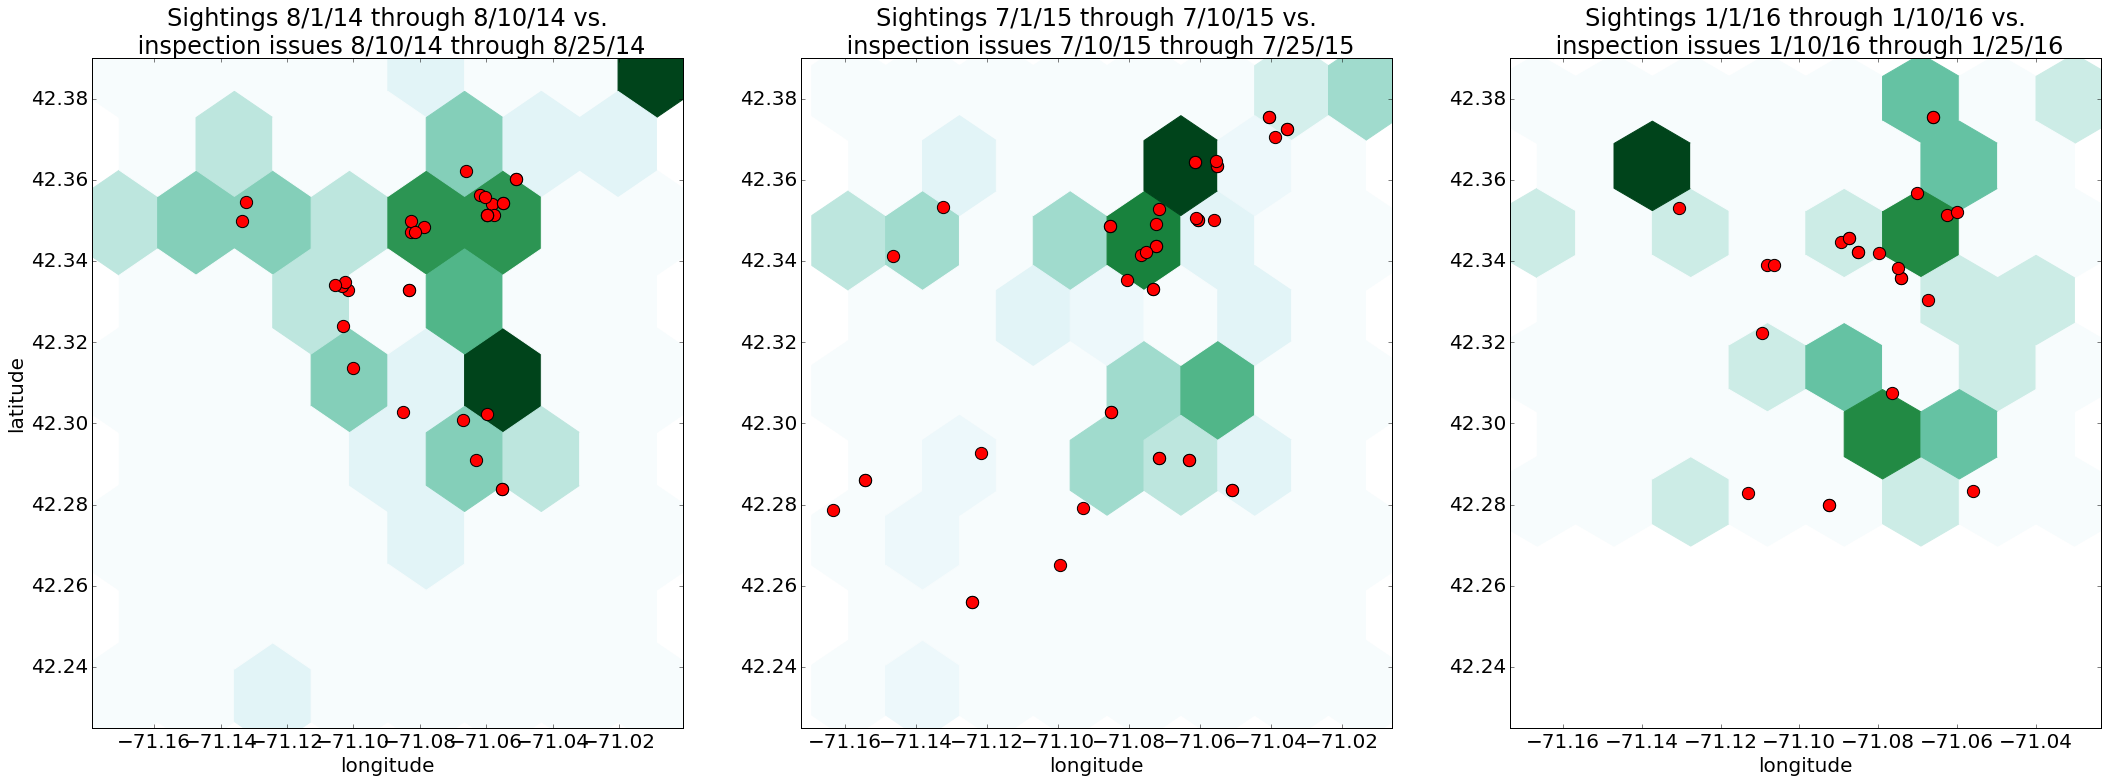

In [19]:
# To visualize spatial patterns of rodent issues...
plt.rcParams['figure.figsize'] = (36, 12)
plt.rcParams['font.size'] = 20
# Plot the geographical distribution of rodent-related service requests in a certain time period:
ax = plt.subplot(1,3,3)
services[
    (services.title.fillna('').str.contains('odent')) &
    ('2016-01-01 00:00:00' <= services.open) &
    (services.open <= '2016-01-10 00:00:00')
].plot.hexbin(x='longitude',y='latitude',gridsize=[7,3],colorbar=False,ax=ax,ylim=[42.225,42.39])
# Show the locations of all inspections with mentions of rodents in a subsequent time period:
inspections[
    (inspections.description.fillna('').str.contains('odent')) &
    ('2016-01-10 00:00:00' <= inspections.result_date) &
    (inspections.result_date <= '2016-01-25 00:00:00')
].plot(x='longitude',y='latitude',kind='scatter',ax=ax,color='red', s=150)
plt.ylabel('')
ax.set_title('Sightings 1/1/16 through 1/10/16 vs.\n inspection issues 1/10/16 through 1/25/16')

# Repeat the steps above for a second period of time:
ax = plt.subplot(1,3,2)
services[
    (services.title.fillna('').str.contains('odent')) &
    ('2015-07-01 00:00:00' <= services.open) &
    (services.open <= '2015-07-10 00:00:00')
].plot.hexbin(x='longitude',y='latitude',gridsize=7,colorbar=False, ax=ax,ylim=[42.225,42.39])
inspections[
    (inspections.description.fillna('').str.contains('odent')) &
    ('2015-07-10 00:00:00' <= inspections.result_date) &
    (inspections.result_date <= '2015-07-25 00:00:00')
].plot(x='longitude',y='latitude',kind='scatter',ax=ax,color='red', s=150)
plt.ylabel('')
ax.set_title('Sightings 7/1/15 through 7/10/15 vs.\n inspection issues 7/10/15 through 7/25/15')

# Repeat the steps above for a third period of time:
ax = plt.subplot(1,3,1)
services[
    (services.title.fillna('').str.contains('odent')) &
    ('2014-08-01 00:00:00' <= services.open) &
    (services.open <= '2014-08-10 00:00:00')
].plot.hexbin(x='longitude',y='latitude',gridsize=7,colorbar=False,ax=ax,ylim=[42.225,42.39])
inspections[
    (inspections.description.fillna('').str.contains('odent')) &
    ('2014-08-10 00:00:00' <= inspections.result_date) &
    (inspections.result_date <= '2014-08-25 00:00:00')
].plot(x='longitude',y='latitude',kind='scatter',ax=ax,color='red', s=150)
ax.set_title('Sightings 8/1/14 through 8/10/14 vs.\n inspection issues 8/10/14 through 8/25/14')
None

In [20]:
# Determine which reason(s) correspond(s) to rodent sightings:
services[services.title.fillna('').str.contains('odent')].reason.value_counts()

Environmental Services    10677
Street Lights                 1
Highway Maintenance           1
Name: reason, dtype: int64

In [21]:
# Dump the "inspections" dataframe, since it won't be used for anything going forward:
%reset_selective -f inspections

# Features

In [22]:
# Suppress "chained assignment" warnings:
pd.options.mode.chained_assignment = None

# Create empty columns for each of the "reasons":
for j in range(len(reason)):
    violations[reason[j]] = nan

# Create an empty "delay" column:
violations['delay'] = nan

# Get the integer positions of the reason columns:
reasoncols = reason.apply(violations.columns.get_loc)

# Fill in the new columns, row-by-row:
for row in range(len(violations)):
    # Location of current inspection:
    c = (violations.latitude.iloc[row], violations.longitude.iloc[row])
    # Restaurant ID of current inspection:
    ri = violations.restaurant_id.iloc[row]
    # Date of current inspection:
    t = violations.date.iloc[row]
    # Date of most recent previous inspection of current restaurant:
    tlast = violations[(violations.date <= t - timedelta(days = 1)) & (violations.restaurant_id == ri)].date.max()
    # Calculate the "delay" (time elapsed since last inspection):
    violations['delay'].iloc[row] = t - tlast
    # Get all service calls near the current restaurant in the recent past:
    s = services[
            (services.open < t - timedelta(days = 5)) &
            (services.open > t - timedelta(days = 15)) &
            ((services.latitude - c[0])**2 + (5/7*(services.longitude - c[1]))**2 < 0.0025)
    ]
    # Count and record the number of times each "reason" occurred:
    violations.iloc[row, reasoncols] = s.groupby('reason').count().iloc[:,0][reason].fillna(0).values

# Convert the "delays" to raw numbers (rather than datetime objects):
violations['delay'] = (violations.delay) / (timedelta(days=1))
violations['delay'] = violations.delay.astype(float)

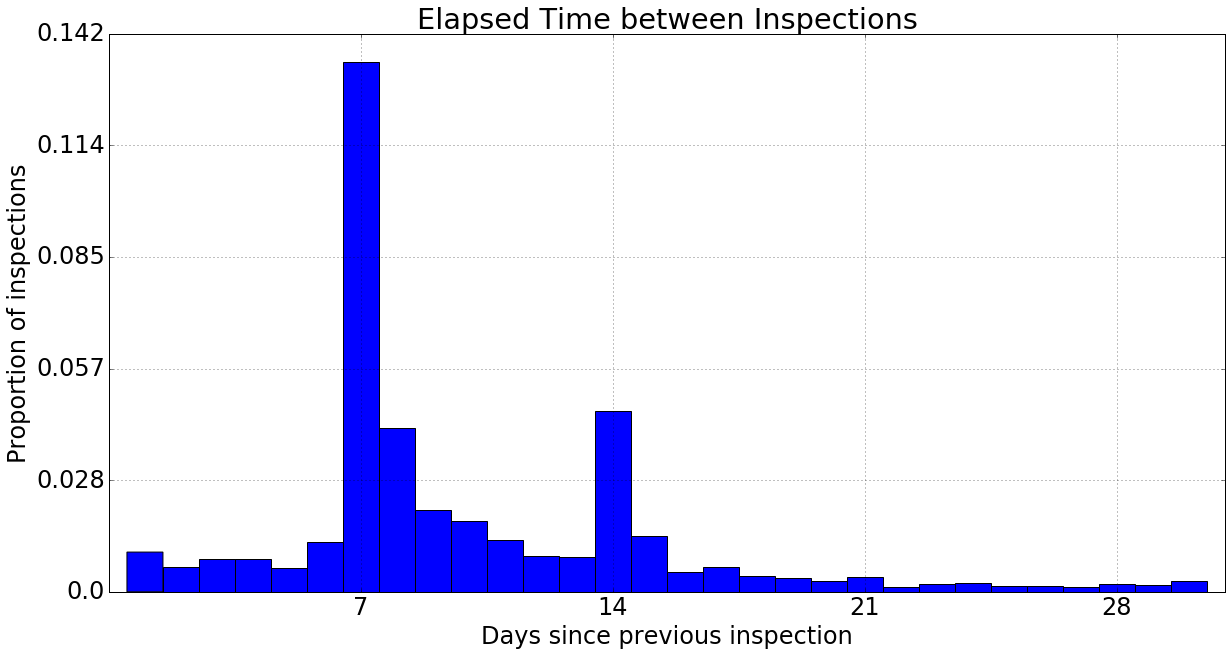

In [23]:
# To visualize the timing of inspections that take place within a month of their predecessors...
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 24
# Create a histogram:
ax = violations.delay.hist(
    bins=range(1, 32), 
    align='left'
)
ax.set_xlim([0,31])
ax.set_xticks([7,14,21,28])
# Show proportions rather than raw counts on the "y" axis:
ax.set_yticklabels(np.round(ax.get_yticks()/len(violations),3))
# Labeling:
ax.set_xlabel('Days since previous inspection')
ax.set_ylabel('Proportion of inspections')
ax.set_title('Elapsed Time between Inspections')
None

# Inference
Some of the following code is adapted from [Allen Downey's ``HypothesisTest`` class](https://github.com/AllenDowney/CompStats/blob/master/hypothesis.ipynb).

In [24]:
class HypothesisTest(object):
    """Represents a hypothesis test."""

    def __init__(self, data):
        """Initializes.

        data: data in whatever form is relevant
        """
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)
        self.test_stats = None

    def PValue(self, iters=1000):
        """Computes the distribution of the test statistic and p-value.

        iters: number of iterations

        returns: float p-value
        """
        self.test_stats = np.array([self.TestStatistic(self.RunModel()) 
                                       for _ in range(iters)])

        count = sum(self.test_stats >= self.actual)
        return count / iters

    def MaxTestStat(self):
        """Returns the largest test statistic seen during simulations.
        """
        return max(self.test_stats)

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        raise UnimplementedMethodException()

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        pass

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        raise UnimplementedMethodException()


class DiffPropsPermute(HypothesisTest):
    """Tests a difference in proportions by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        test_stat = abs(sum(group1)/len(group1) - sum(group2)/len(group2))
        return test_stat

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [25]:
# Show some descriptive statistics for the number of "environmental services" complaints near inspected businesses:
violations['Environmental Services'].describe()

count    17557.000000
mean        43.788745
std         28.287893
min          0.000000
25%         21.000000
50%         38.000000
75%         61.000000
max        167.000000
Name: Environmental Services, dtype: float64

In [26]:
# Test whether businesses near more than 21 "environmental services" complaints have 
# a different rate of inspection failure than others:
set1 = violations[(violations.delay > 14) & (violations['Environmental Services'] <= 21)][['*','**','***']]
set2 = violations[(violations.delay > 14) & (violations['Environmental Services'] > 21)][['*','**','***']]
data1 = (set1['*'] + set1['**'] + set1['***'] > 0)
data2 = (set2['*'] + set2['**'] + set2['***'] > 0)
ht_data = (data1, data2)
ht = DiffPropsPermute(ht_data)
# Display the sample difference in proportions and the p-value:
(ht.TestStatistic(ht_data), ht.PValue(iters = 1000))

(0.30257639334266756, 0.0)

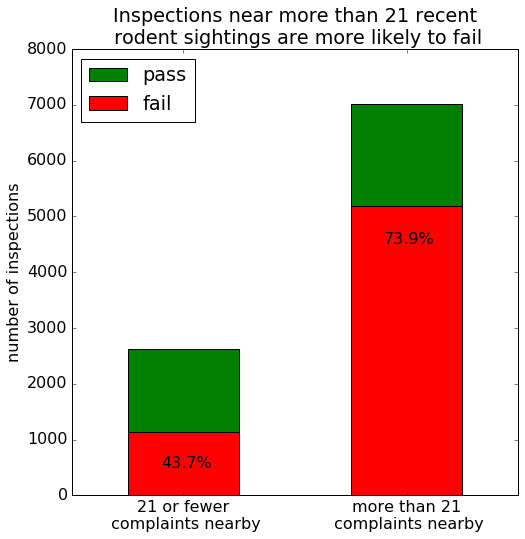

In [27]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 16
df=pd.DataFrame([
    ['21 or fewer\n complaints nearby', len(data1), sum(data1)],
    ['more than 21\n complaints nearby', len(data2), sum(data2)]
]).set_index(0).rename(columns = {1:'pass', 2:'fail'})
ax = df['pass'].plot(
    kind = 'bar', color = 'green', rot = 0
)
df['fail'].plot(
    kind = 'bar', ax=ax, color = 'red', rot = 0
)
plt.text(-.1, 500, str(round(sum(data1)/len(data1)*100,1))+'%')
plt.text(.9, 4500, str(round(sum(data2)/len(data2)*100,1))+'%')
plt.xlabel('')
plt.ylabel('number of inspections')
plt.legend(loc = 0)
plt.title('Inspections near more than 21 recent\n rodent sightings are more likely to fail')
plt.show()

In [28]:
# Repeat the same kind of test as done above for every "reason":
test_table = pd.DataFrame()
for r in reason:
    # Find the first quartile:
    Q1 = np.percentile(violations[r], 25)
    test_table.loc[r, 'Q1'] = Q1
    # Run the hypothesis test:
    set1 = violations[(violations.delay > 14) & (violations[r] <= Q1)][['*','**','***']]
    set2 = violations[(violations.delay > 14) & (violations[r] > Q1)][['*','**','***']]
    data1 = (set1['*'] + set1['**'] + set1['***'] > 0)
    data2 = (set2['*'] + set2['**'] + set2['***'] > 0)
    ht_data = (data1, data2)
    ht = DiffPropsPermute(ht_data)
    # Store the results:
    test_table.loc[r, 'difference'] = ht.TestStatistic(ht_data)
    test_table.loc[r, 'p-value'] = ht.PValue(iters = 1000)

# Display all results:
test_table

,Q1,difference,p-value
Sanitation,244.0,0.283919,0.000
Highway Maintenance,225.0,0.398662,0.000
Street Cleaning,105.0,0.120231,0.000
Street Lights,127.0,0.064507,0.000
Signs & Signals,77.0,0.121797,0.000
Housing,74.0,0.146075,0.000
Recycling,36.0,0.403072,0.000
Enforcement & Abandoned Vehicles,29.0,0.200246,0.000
Building,43.0,0.404795,0.000
Trees,22.0,0.535288,0.000


# Building Models

In [29]:
# To finalize the features and targets that predictive models will use...
# Cut all re-inspections out of the data and randomize the order of the dataset:
violations_ = violations[violations.delay > 14].sample(frac = 1)
# Make room for three last model features:
violations_['last1'] = nan   # The number of one-star violations found at the last inspection
violations_['last2'] = nan   # The number of two-star violations found at the last inspection.
violations_['last3'] = nan   # The number of three-star violations found at the last inspection.
# Fill in the new features, row-by-row:
for row in range(len(violations_)):
    # Get the current inspection's restaurant ID:
    ri = violations_.restaurant_id.iloc[row]
    # Get the date of the current inspection:
    t = violations_.date.iloc[row]
    # Get the details from the previous inspections of this restaurant, with the most recent first:
    last = violations_[
        (violations_.date <= t - timedelta(days = 1)) &
        (violations_.restaurant_id == ri)
    ].sort_values('date', ascending = False)
    # If there even was a previous inspection, record the violation counts:
    if len(last) > 0:
        violations_['last1'].iloc[row] = last['*'].iloc[0]
        violations_['last2'].iloc[row] = last['**'].iloc[0]
        violations_['last3'].iloc[row] = last['***'].iloc[0]
# Build the features matrix, filling in zero previous violations for any restaurant with no previous inspection: 
X = violations_.drop([
        'date', 'restaurant_id', '*', '**', '***', 'name'
    ],1).fillna(0)
# Build the targets vector ("1" for failed inspections, "0" for passed):
y = (violations_['*'] + violations_['**'] + violations_['***'] > 0).astype(np.int)

In [30]:
# Take a look at one particular day of features and targets:
violations_[
    violations_.date == '2014-07-23'
].drop(['date','*','**','***','name','restaurant_id'], 1).join(
    pd.DataFrame(y[violations_.date == '2014-07-23'])
).rename(columns = {0:'targets'})

,latitude,longitude,Sanitation,Highway Maintenance,Street Cleaning,Street Lights,Signs & Signals,Housing,Recycling,Enforcement & Abandoned Vehicles,...,Neighborhood Services Issues,Valet,Administration,Massport,Air Pollution Control,delay,last1,last2,last3,targets
5480,42.310438,-71.115151,759.0,490.0,300.0,117.0,175.0,197.0,117.0,54.0,...,0.0,0.0,0.0,1.0,0.0,182.0,0.0,0.0,0.0,0
15345,42.361317,-71.052423,454.0,318.0,108.0,159.0,129.0,120.0,79.0,39.0,...,0.0,1.0,0.0,0.0,0.0,30.0,4.0,0.0,0.0,1
6002,42.312270,-71.114178,769.0,500.0,297.0,118.0,180.0,193.0,114.0,53.0,...,0.0,0.0,0.0,1.0,0.0,196.0,0.0,0.0,0.0,1
28597,42.361041,-71.067990,496.0,330.0,114.0,165.0,136.0,144.0,86.0,40.0,...,0.0,1.0,0.0,1.0,0.0,91.0,0.0,0.0,0.0,1


In [31]:
# View the number of samples and features:
X.shape

(9641, 60)

In [32]:
# View the proportion of targets that are failed:
sum(y)/len(y)

0.65677834249559175

In [33]:
# To build a logistic regression classifier...
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegressionCV

# Prepare training and test data:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.8, stratify = y)

# Search (with cross-validation) for the best hyperparameter:
clf_LR = LogisticRegressionCV(
    Cs = np.logspace(-.1, 1.3, 100), 
    cv = 3, 
    # Use all available cores:
    n_jobs = -1
)
clf_LR.fit(Xtrain, ytrain)

# Display the best hyperparameter:
clf_LR.C_

array([ 1.62596469])

In [34]:
# Show the accuracy on the training and test sets:
clf_LR.score(Xtrain, ytrain), clf_LR.score(Xtest, ytest)

(0.83596991701244816, 0.82270606531881807)

In [35]:
# To build a decision tree classifier...
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV

# Prepare training and test data:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.8, stratify = y)


# Search (with cross-validation) for the best hyperparameters for the tree:
gs = GridSearchCV(
        estimator = DecisionTreeClassifier(),
        param_grid = {
            'max_depth' : np.arange(3, 12, 1),
            'min_samples_leaf' : np.arange(5, 20, 1)
        },
        # Use all available cores:
        n_jobs = -1
)
gs.fit(Xtrain, ytrain)

# Save the best tree that was found:
clf_tree = gs.best_estimator_

# Display the best hyperparameters:
gs.best_params_

{'max_depth': 5, 'min_samples_leaf': 7}

In [36]:
# Show the accuracy on the training and test sets:
clf_tree.score(Xtrain, ytrain), clf_tree.score(Xtest, ytest)

(0.85488589211618261, 0.84173665111456709)

In [37]:
# To build a support vector machine classifier (SVC)...
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import warnings

# Prepare training and test data:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.8, stratify = y)

# Standardize the training features:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)

# Search (with cross-validation) for the best hyperparameters for the SVC:
gs = GridSearchCV(
        estimator = SVC(probability = True),
        param_grid = {
            'C' : np.logspace(-1, 1, 5),
            'gamma' : np.logspace(-4, 0, 9),
        },
        # Use all available cores:
        n_jobs = -1
)
# Suppress an erroneous warning
# (see https://github.com/scikit-learn/scikit-learn/issues/6370):
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    gs.fit(Xtrain, ytrain)

# Save the best SVC that was found:
clf_SVM = gs.best_estimator_

# Display the best hyperparameters:
gs.best_params_

{'C': 1.0, 'gamma': 0.031622776601683791}

In [38]:
# Show the accuracy on the training and test sets:
clf_SVM.score(Xtrain, ytrain), clf_SVM.score(scaler.transform(Xtest), ytest)

(0.87227697095435686, 0.86365992742353548)

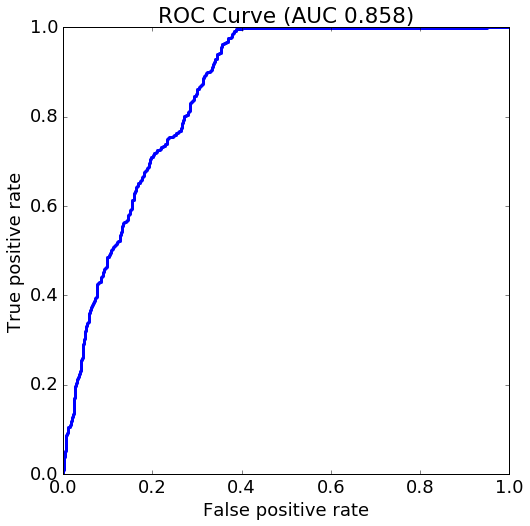

In [39]:
# Display the ROC curve and calculate the AUC:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 18
xroc, yroc, _ = roc_curve(ytest, clf_SVM.predict_proba(scaler.transform(Xtest))[:,1])
plt.plot(xroc, yroc, linewidth = 3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve (AUC ' + str(round(auc(xroc,yroc), 3)) + ')')
plt.show()

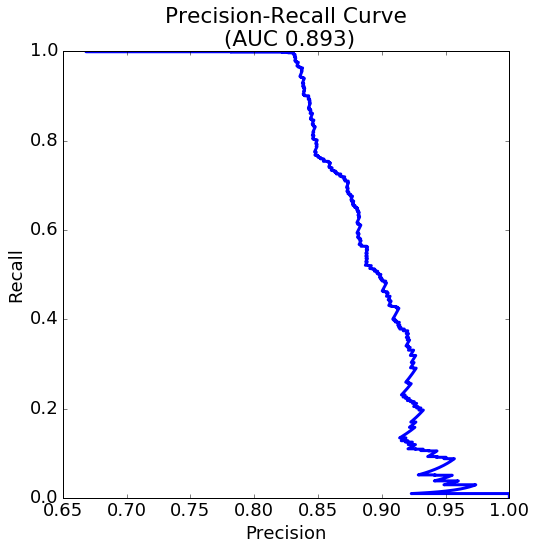

In [40]:
# Show the precision-recall curve and its AUC:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
xprc, yprc, _ = precision_recall_curve(ytest, clf_SVM.predict_proba(scaler.transform(Xtest))[:,1])
plt.plot(xprc, yprc, linewidth = 3)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve\n (AUC ' + str(round(
            average_precision_score(ytest, clf_SVM.predict_proba(scaler.transform(Xtest))[:,1]), 3)) + ')')
plt.show()

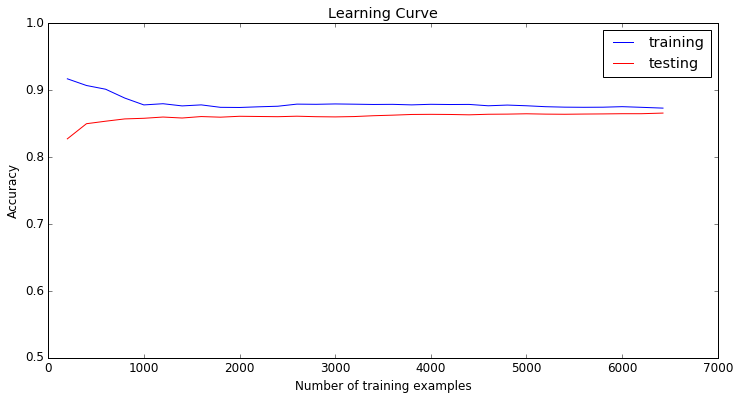

In [41]:
# Create the learning curve:
from sklearn.learning_curve import learning_curve
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    train_size, train_score, test_score = learning_curve(
        clf_SVM, 
        scaler.transform(X), 
        y, 
        n_jobs = -1,
        train_sizes = np.hstack((np.arange(200, 6400, 200), 6427))
    )
plt.plot(
    train_size, 
    train_score.mean(axis = 1), 
    label='training'
)
plt.plot(
    train_size, 
    test_score.mean(axis = 1), 
    label='testing', c='red'
)
plt.legend(loc = 0)
plt.ylim([0.5, 1])
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.show()

In [42]:
# To build a random forest classifier...
from sklearn.ensemble import RandomForestClassifier

# Prepare training and test data:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.8, stratify = y)

# Search (with cross-validation) for the best hyperparameters:
gs = GridSearchCV(
        estimator = RandomForestClassifier(n_estimators = 800),
        param_grid = {
            'max_features' : np.arange(6, 10, 1),
            'min_samples_leaf' : np.arange(1, 9, 1),
            'min_samples_split' : np.arange(2, 9, 1)
        },
        # Use all cores:
        n_jobs = -1
)
gs.fit(Xtrain, ytrain)

# Save the best random forest that was found:
clf_RF = gs.best_estimator_

# Display the best hyperparameters:
gs.best_params_

{'max_features': 6, 'min_samples_leaf': 4, 'min_samples_split': 3}

In [43]:
# Show the accuracy on the training and test sets:
clf_RF.score(Xtrain, ytrain), clf_RF.score(Xtest, ytest)

(0.91312240663900412, 0.87817522032141004)

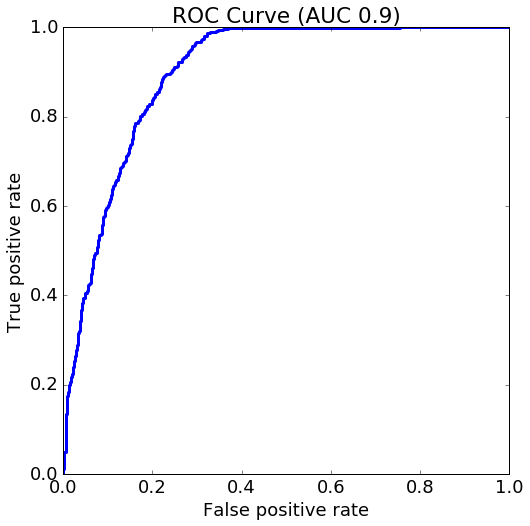

In [44]:
# Graph the ROC curve and find the AUC:
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 18
xroc, yroc, _ = roc_curve(ytest, clf_RF.predict_proba(Xtest)[:,1])
plt.plot(xroc, yroc, linewidth=3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve (AUC ' + str(round(auc(xroc,yroc), 3)) + ')')
plt.show()

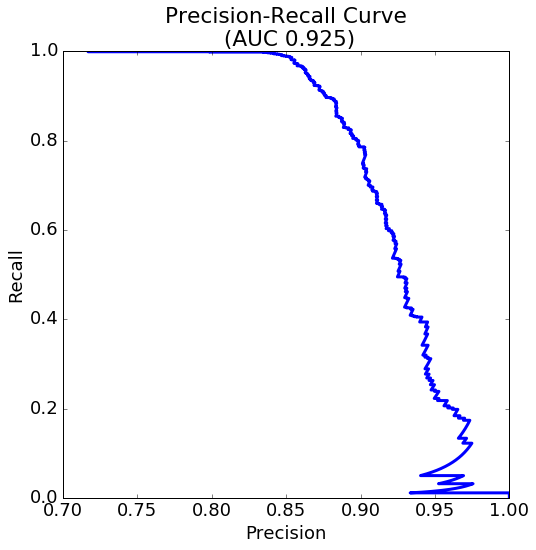

In [45]:
# Display the precision-recall curve and its AUC:
xprc, yprc, _ = precision_recall_curve(ytest, clf_RF.predict_proba(Xtest)[:,1])
plt.plot(xprc, yprc, linewidth=3)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve\n (AUC ' + str(round(
            average_precision_score(ytest, clf_RF.predict_proba(Xtest)[:,1]), 3)) + ')')
plt.show()

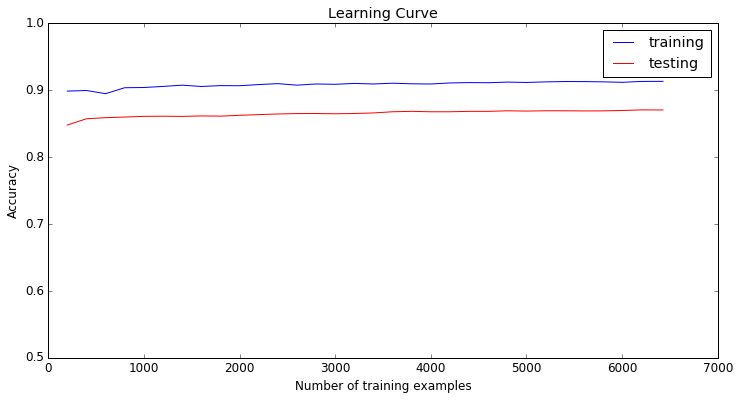

In [46]:
# Show the learning curve:
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

train_size, train_score, test_score = learning_curve(
    clf_RF, 
    X, 
    y, 
    n_jobs = -1,
    train_sizes = np.hstack((np.arange(200, 6400, 200), 6427))
)
plt.plot(
    train_size, 
    train_score.mean(axis = 1), 
    label='training'
)
plt.plot(
    train_size, 
    test_score.mean(axis = 1), 
    label='testing', c='red'
)
plt.legend(loc = 0)
plt.ylim([0.5,1])
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.show()

In [47]:
# Find the importances of the features, and list them in order of descending importance:
featurelist = pd.DataFrame()
featurelist['name'] = X.columns
featurelist['importance'] = clf_RF.feature_importances_
featurelist.sort_values('importance', ascending = False)

,name,importance
11,Trees,0.101873
3,Highway Maintenance,0.072970
8,Recycling,0.062076
10,Building,0.048109
14,Environmental Services,0.047405
23,Traffic Management & Engineering,0.039442
20,Health,0.033928
12,Graffiti,0.033234
35,Weights and Measures,0.031877
22,Operations,0.029097


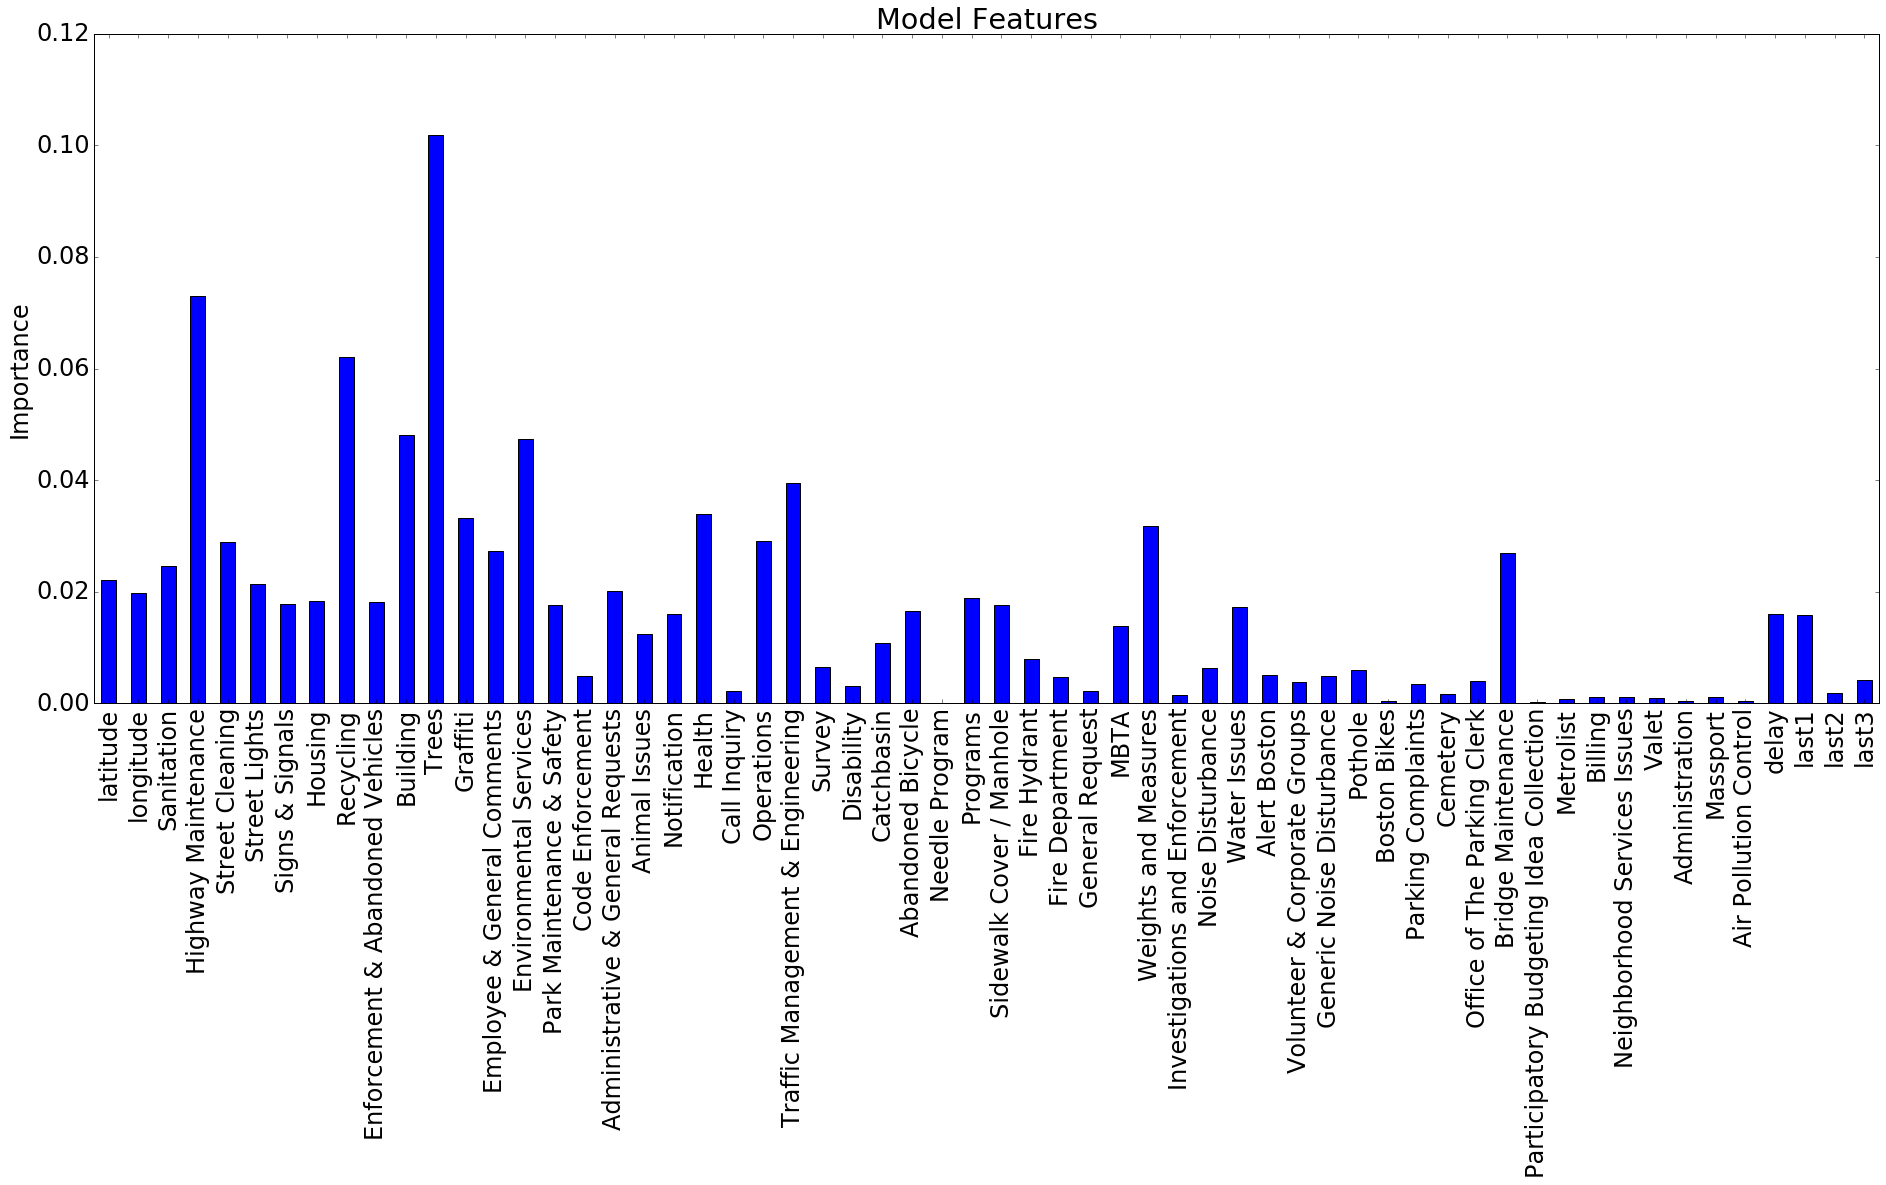

In [48]:
# Visualize the importances:
plt.rcParams['figure.figsize'] = (32, 12)
plt.rcParams['font.size'] = 24
ax = featurelist.plot(kind='bar')
ax.set_xticklabels(featurelist['name'])
ax.legend_.remove()
ax.set_title('Model Features')
ax.set_ylabel('Importance')
None

In [49]:
# To build an extra-trees classifier...
from sklearn.ensemble import ExtraTreesClassifier

# Prepare training and test data:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.8, stratify = y)

# Search (with cross-validation) for the best hyperparameters:
gs = GridSearchCV(
        estimator = ExtraTreesClassifier(bootstrap = True),
        param_grid = {
            'max_features' : np.arange(5, 60, 10),
            'min_samples_leaf' : np.arange(1, 7, 1),
            'min_samples_split' : np.arange(4, 10, 1),
            'n_estimators' : np.arange(50, 500, 100)
        },
        # Use all cores:
        n_jobs = -1
)
gs.fit(Xtrain, ytrain)

# Save the best classifier that was found:
clf_ET = gs.best_estimator_

# Display the best hyperparameters:
gs.best_params_

{'max_features': 25,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 150}

In [50]:
# Show the accuracy on the training and test sets:
clf_ET.score(Xtrain, ytrain), clf_ET.score(Xtest, ytest)

(0.943853734439834, 0.86521513737687916)

# Comparison to DrivenData Contest

In [51]:
# Create a new set of features, very similar to the others, but for fairness,
# use EVERY reported inspection result (including the mislabeled re-inspections):
violations__ = violations.sample(frac = 1)
violations__['last1'] = nan
violations__['last2'] = nan
violations__['last3'] = nan
for row in range(len(violations__)):
    ri = violations__.restaurant_id.iloc[row]
    t = violations__.date.iloc[row]
    last = violations__[
        (violations__.date <= t - timedelta(days = 1)) &
        (violations__.restaurant_id == ri)
    ].sort_values('date', ascending = False)
    if len(last) > 0:
        violations__['last1'].iloc[row] = last['*'].iloc[0]
        violations__['last2'].iloc[row] = last['**'].iloc[0]
        violations__['last3'].iloc[row] = last['***'].iloc[0]
X = violations__.drop([
        'date', 'restaurant_id', '*', '**', '***', 'name'
    ],1).fillna(0)
# Here, the targets are designed for regression, not classification:
y = violations__[['*', '**', '***']]

In [52]:
# A weighted root mean square log error scorer for regression models:
def WRMSLE(rm, X, y):
    # Weights:
    W = np.array([[1],[2],[5]])
    # Note that the error is taken to be negative, because GridSearchCV will attempt to maximize it:
    return -np.sqrt(
        sum(
            (
                np.log(np.dot(y.values, W) + 1) - np.log(np.dot(rm.predict(X).round(), W) + 1)
            )**2
        )/len(y)
    )[0]

In [53]:
# To build a random forest classifier...
from sklearn.ensemble import RandomForestRegressor

# Prepare training and test data:
Xtrain = X[violations__.date < '2015-05-14']
ytrain = y[violations__.date < '2015-05-14']
# 5/14/2015 through 6/25/2015 are the last 6 weeks of data available:
Xtest = X[violations__.date >= '2015-05-14']
ytest = y[violations__.date >= '2015-05-14']

# Search (with cross-validation) for the best hyperparameters:
gs = GridSearchCV(
        estimator = RandomForestRegressor(n_estimators = 800),
        param_grid = {
            'max_features' : np.arange(5, 60, 5),
            'min_samples_leaf' : np.arange(1, 9, 1),
            'min_samples_split' : np.arange(1, 9, 1)
        },
        # Use all available cores
        # (due to a known bug, this line should be removed for proper execution in Windows):
        n_jobs = -1,
        # Attempt to optimize for the weighted root mean square log error:
        scoring = WRMSLE
)
gs.fit(Xtrain, ytrain)

# Save the best regression model that was found:
rm = gs.best_estimator_
# Display the best hyperparameters:
gs.best_params_

{'max_features': 40,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 800}

In [54]:
# Show the weighted root mean square log error of the model on the test data:
-WRMSLE(rm, Xtest, ytest)

0.85963736803885515